# Introduction

In this notebook, we will compare the PM 2.5 measurements taken by the low-cost sensors developed by UMD SENSE (http://sense.umd.edu/) with the high-cost sensors already in use by the EPA. This will be done by creating a few visualizations and comparing the measurements over time. We will also take a look at some basic descriptive statistics to see how accurate our low-cost sensors are. Our goal is to see whether our sensors can be reliable enough to be deployed on a larger scale. If the sensor measurements aren't accurate enough, we will go deeper to see if there are any factors that are affecting the measurements like temperature, wind speed, atmospheric pressure, etc. 

For this purpose, we will be using four datasets in total (2 each for EPA and SENSE) that contain measurements for PM 2.5 at two locations in the DMV area: DC DOEE montoring station and Howard Univeristy, Beltsville, MD. We will be comparing data from 06/01/19 to 12/13/19. 

In [1]:
#Importing required libraries
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from glob import glob
import os
import warnings
pd.options.mode.chained_assignment = None

In [2]:
#Defining the path and the extension of the required files
PATH = "."
EXT = "*.csv"
#Fetching and storing the names of the required files in all_csv_files
all_csv_files = []
for path, subdir, files in os.walk(PATH):
    for file in glob(os.path.join(path, EXT)):
        all_csv_files.append(file)

In [3]:
#Checking if all files are fetched
all_csv_files

['.\\EPA Datasets\\dc_p_epa.csv',
 '.\\EPA Datasets\\howard_p_epa.csv',
 '.\\SENSE Datasets\\dc_p_s.csv',
 '.\\SENSE Datasets\\howard_p_s.csv']

# Functions

In order to comapre the PM 2.5 values, the two dataframes (EPA and SENSE) for each location, must be merged on their date-time values. Before merging and creating the final visualization, the data needs to undergo some processing. The following functions must be implemented for this:

1) Drop unnecessary columns<br />
2) Remove negative PM values<br />
3) Create a date-time column with the format YYYY-MM-DD HH:MM:SS and drop the old date and time columns<br />
4) Merge on the date-time values for each location<br />
5) Add another column that measures the rolling mean (for a smoother graph) for both the EPA and the SENSE data for each location<br />
6) Create the plot for each location<br />

In [4]:
def drop_col(x):
    """Drop the unnecessary columns in EPA dataframe (has no effect on SENSE dataframe)"""
    if('State Code' in x.columns):
                x.drop(['State Code', 'Datum', 'Parameter Name', 'Date GMT', 'Time GMT', 'Units of Measure',
                     'County Code', 'Site Num', 'Parameter Code', 'POC', 'Latitude', 'Longitude', 'MDL', 
                     'Method Type', 'Method Name', 'State Name', 'County Name', 'Date of Last Change', 
                     'Uncertainty', 'Qualifier', 'Method Code'], axis = 1, inplace = True)
    return x
    

In [5]:
def remove_negative(x):
    """Return the SENSE or EPA dataframe with the negative PM2.5 values removed."""
    if('Sample Measurement' in x.columns):
        mask = x['Sample Measurement'] < 0
        x = x[~mask]
    else:
        mask = x['PM25'] < 0
        x = x[~mask]
    return x

In [6]:
def date_time(y):
    """Returns the SENSE or EPA dataframe with a new time column in the format YYYY-MM-DD HH:MM:SS."""
    if('Date Local' and 'Time Local' in y.columns):
        y['Time'] = (y['Date Local'] + " "
                     + y['Time Local']).apply(lambda x: datetime.datetime.strptime(x, '%m/%d/%Y %H:%M'))
        y.drop(['Date Local', 'Time Local'], axis = 1, inplace = True)
    else:
        y.rename(columns = {'data_time': 'Time'}, inplace = True)
        y['Time'] = y['Time'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
    return y

In [7]:
def merge(x,y):
    """Merges the SENSE and EPA dataframe on their Time column, adds a new Error column which calculates the 
    absolute error, and renames the columns to identify the measurements taken by each sensor."""
    merged = pd.merge(x,y, on = 'Time')
    merged['Error'] = merged['Sample Measurement'] - merged['PM25']
    merged = merged.rename(columns = {'Sample Measurement' : 'EPA', 'PM25': 'SENSE'})
    return merged

In [8]:
def smoothen(x):
    """Calculates the rolling mean for both sensor measurements which will be used for a smoother plot."""
    x['SENSE(rolling mean)'] = x['SENSE'].rolling(24).mean()
    x['EPA(rolling mean)'] = x['EPA'].rolling(24).mean()
    x = x[23:]
    return x
        

In [9]:
def plot(x,n):
    """Plots two subplots: one with the regular PM 2.5 values and the other with rolling mean PM 2.5 values. """
    fig, axes = plt.subplots(nrows=2, ncols=1)
    x.plot(x = "Time", y = ["SENSE", "EPA"], figsize = (15,4), ax=axes[0])
    x.plot(x="Time", y=["SENSE(rolling mean)", "EPA(rolling mean)"], figsize = (15,4), ax=axes[1], sharex = axes[0])
    axes[0].set_xlabel('Time')
    axes[0].set_ylabel('PM2.5(µg/m3)')
    axes[1].set_xlabel('Time')
    axes[1].set_ylabel('PM2.5(µg/m3)')
    fig.tight_layout()
    fig.suptitle("EPA and SENSE Sensor Measurements of PM 2.5 at " + n, y = 1.04)

In [10]:
#Preprocessing for the individual datasets
list_df = {}
dfs = ('epa_dc', 'epa_howard', 'sense_dc', 'sense_howard')
for d,f in zip(dfs,all_csv_files):
    list_df[d] = pd.read_csv(f)
    list_df[d] = list_df[d].pipe(drop_col).pipe(remove_negative).pipe(date_time)

In [11]:
#Merging the EPA and SENSE dataframes for each location
dc = merge(list_df['epa_dc'], list_df['sense_dc'])
howard = merge(list_df['epa_howard'], list_df['sense_howard'])

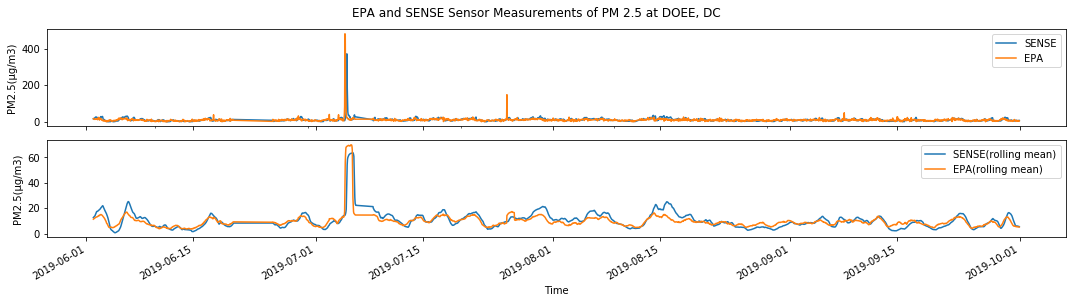

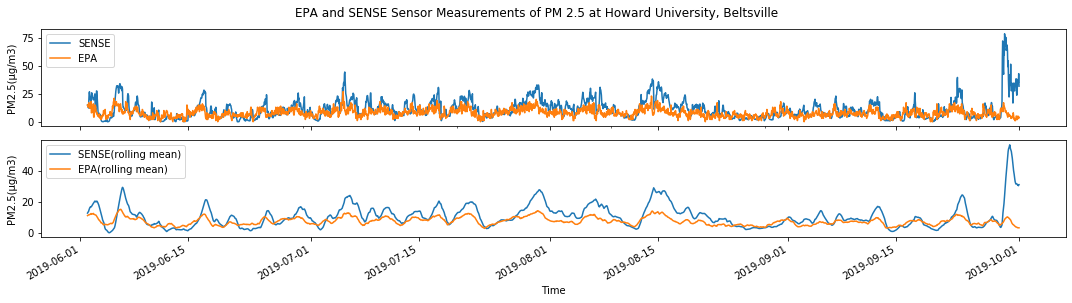

In [13]:
#Plotting the graphs
for x,y in zip([dc, howard], ["DOEE, DC", "Howard University, Beltsville"]):
    x.pipe(smoothen).pipe(plot, y)

# Conclusions

